This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576)

In [1]:
import scipy.io
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Text(0.5,1,'style image')

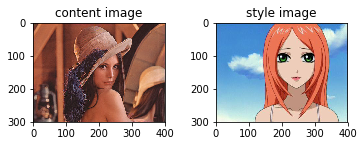

In [2]:
content_image = scipy.misc.imread("data/lenna.jpg")
style_image = scipy.misc.imread("data/cartoon.jpg")
plt.subplot(2, 2, 1)
plt.imshow(content_image)
plt.title('content image')
plt.subplot(2, 2, 2)
plt.imshow(style_image)
plt.title('style image')

In [3]:
import tensorflow as tf

In [4]:
#Import a pre trained model: vgg
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0] #vgg_layers[0][layer][0][0][-2]
#         print(vgg_layers[0][layer][0][0][2][0][0])
#         print(vgg_layers[0][layer][0][0][0][0][1])
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [5]:
model = load_vgg_model("pretrained_model/imagenet-vgg-verydeep-19.mat")

In [6]:
print(model)

{'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150

Next, you can find functions that are needed to calculate the cost of the neural style transfer

In [7]:
def content_cost(C, G):
    """
    Arguments:
    C: tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    G: tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content: cost between the content image and the generating image.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    C = tf.reshape(C, [m, n_H*n_W, n_C])
    G = tf.reshape(G, [m, n_H*n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(C, G)))/(4*n_H*n_W*n_C)
    return J_content
    
def style_cost(S, G):
    """
    Arguments:
    C: tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    G: tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_style: cost between the style image and the generating image.
    """
    m, n_H, n_W, n_C = G.get_shape().as_list()
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    S = tf.reshape(S, [n_H*n_W, n_C])
    G = tf.reshape(G, [n_H*n_W, n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(S))
    GG = gram_matrix(tf.transpose(G))

    # Computing the loss (≈1 line)
    J_style = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4*((n_H*n_W)**2)*(n_C**2))
    return J_style
    
    
def gram_matrix(A):
    """
    Argument:
    A: matrix of shape (n, m)
    
    Returns:
    GA: Gram matrix of A, of shape (n, n)
    """
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [8]:
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = content_cost(a_C, a_G)
    J_style = style_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
    print("J_style = " + str(J_style.eval()))

J_content = 9.676159
J_style = 4.4911075


In [9]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Arguments:
    J_content: content cost
    J_style: style cost
    alpha: hyperparameter weighting the importance of the content cost
    beta: hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost
    """
    
    J = alpha*J_content+beta*J_style
    return J

In [10]:
# content_image = scipy.misc.imread("data/lenna.jpg")
# style_image = scipy.misc.imread("data/cartoon.jpg")
#reshape the content and teh style images
content_image = content_image.reshape(1,content_image.shape[0],content_image.shape[1],content_image.shape[2])
style_image = style_image.reshape(1,style_image.shape[0],style_image.shape[1],style_image.shape[2])

#normalize the content and teh style images
common_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
content_image = content_image - common_mean
style_image = style_image - common_mean

/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [11]:
# set noise ratio
noise_ratio = 0.8

#generate noise image
noise_image = np.random.uniform(-20, 20, (content_image.shape)).astype('float32')
    
#Set the input_image to be a weighted average of the content_image and a noise_image
input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

In [12]:
sess = tf.InteractiveSession()

#compute content cost
sess.run(model['input'].assign(content_image))

out = model['conv4_2']
a_C = sess.run(out)
J_content = content_cost(a_C, out)


#compute style cost on layers conv2_1, conv3_1, conv4_1 and conv5_1 with weights 0.2, 0.2, 0.3 and 0.3
sess.run(model['input'].assign(style_image))

out = model['conv1_1']
a_S = sess.run(out)
J_style_layer1 = style_cost(a_S, out)

out = model['conv2_1']
a_S = sess.run(out)
J_style_layer2 = style_cost(a_S, out)

out = model['conv3_1']
a_S = sess.run(out)
J_style_layer3 = style_cost(a_S, out)

out = model['conv4_2']
a_S = sess.run(out)
J_style_layer4 = style_cost(a_S, out)

out = model['conv5_1']
a_S = sess.run(out)
J_style_layer5 = style_cost(a_S, out)


J_style = 0.2 * J_style_layer1 + 0.2 * J_style_layer2 + 0.2 * J_style_layer3 + 0.2 * J_style_layer4 + 0.2 * J_style_layer5

In [13]:
#set neural network's hyper parameters
num_iterations = 250
learning_rate = 2.0

#compute total cost
cost = total_cost(J_content, J_style, alpha = 0.2, beta = 0.8)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_step = optimizer.minimize(cost)

In [14]:
#compute learning procedure
sess.run(tf.global_variables_initializer())

sess.run(model['input'].assign(input_image))

for i in range(num_iterations):
    sess.run(train_step)
    generated_image = sess.run(model['input'])

    if i%20 == 0:
        Jt, Jc, Js = sess.run([cost, J_content, J_style])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
Jt, Jc, Js = sess.run([cost, J_content, J_style])
print("Iteration " + str(i) + " :")
print("total cost = " + str(Jt))
print("content cost = " + str(Jc))
print("style cost = " + str(Js))

Iteration 0 :
total cost = 95960790.0
content cost = 15996.237
style cost = 119946984.0
Iteration 20 :
total cost = 33316484.0
content cost = 20147.043
style cost = 41640570.0
Iteration 40 :
total cost = 19820766.0
content cost = 21532.316
style cost = 24770574.0
Iteration 60 :
total cost = 14573443.0
content cost = 22363.943
style cost = 18211212.0
Iteration 80 :
total cost = 11822532.0
content cost = 22923.305
style cost = 14772433.0
Iteration 100 :
total cost = 10059774.0
content cost = 23267.42
style cost = 12568901.0
Iteration 120 :
total cost = 8786607.0
content cost = 23532.16
style cost = 10977376.0
Iteration 140 :
total cost = 7777151.5
content cost = 23744.4
style cost = 9715503.0
Iteration 160 :
total cost = 6945296.0
content cost = 23935.414
style cost = 8675636.0
Iteration 180 :
total cost = 6221638.5
content cost = 24098.863
style cost = 7771023.0
Iteration 200 :
total cost = 5568225.5
content cost = 24265.1
style cost = 6954215.5
Iteration 220 :
total cost = 4986448.0
co

Text(0.5,1,'generated image')

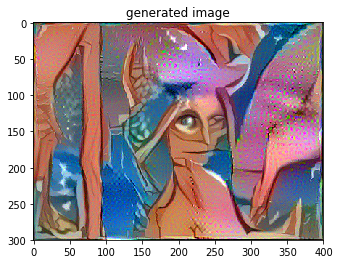

In [15]:
generated_image = generated_image + common_mean
generated_image = np.clip(generated_image[0], 0, 255).astype('uint8')
plt.imshow(generated_image)
plt.title('generated image')